<h1 style="text-align: center;" >Car Price Estimator 3000</h1>                                          

<p align="center">
<img width="650" src="https://www.juststartinvesting.com/" alt="Assignment 2" title="" />
    
</p>
    

# Table of Content: <a class="car" id="table-of-content"></a>
* [1. Problem Background and Motivation](#problem-background)<br>
* [2. Libraries ](#import-packages)<br>
 * [2.1 User Defined Functions](#udf)<br>    
* [3. Data Preparation](#data-prep)<br>
* [4. Machine Learning Model Implementation](#ml-model)<br>
* [5. Deployment of Model](#model-deployment)<br><br>

[Conclusion](#Conclusion)

# 1. Problem Background and Motivation <a class="car" id="problem-background"></a>

### Used Car Price Estimator in AZ 
<img src='https://d3ftmvynp162pm.cloudfront.net/public/album_photo/a2/79/05/49ee6e1194e6eae3afdc10127bf06178.jpg' />

>**What is the problem in Question?**<br>
>  There is a huge market for selling and buying of second hand cars. Our model uses various parameter such as make, model, year, horse power to predict our target which is maximum selling price. <br><br>

>**Who will be our stakeholders?**<br>
> * Sellers who are looking for a fair estimate of their cars.<br>
> * Retailers who are putting these cars on the market.<br> 
> * Car companies introducing new cars.<br><br>

>**What will be the Conclusion?**<br>
> People can leverage this information into getting a better price and reduce all the haggling with the sellers.<br>Helps car companies to estimate a fair price of their car and also to know the competition better.




# 2. Libraries Used <a class="car" id="import-packages"></a>
* [Go to Top](#table-of-content)

In [72]:
######################################
# Importing various python libraries
#  1. Pandas is a data analysis and manipulation library. We are using it to read the datasets
#  2. sklearn is machine learning library of python. we need it for running the prediction model.
#  3. Multiple visualization libraries are given below
######################################
import pandas as pd
import numpy as np

import math

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error

import statsmodels.api as sm

pd.set_option('display.max_columns', None)

pd.options.display.float_format = '{:,.2f}'.format

## 2.1 User Defined Functions <a class="car" id="udf"></a>
* [Go to Top](#table-of-content)

In [73]:
#########################
#Additional user defined functions 
#########################


def data_stats(df,feature_list):
    '''
    This function we are calculating basic stats for all numerical columns. 
    To indicate outlier presence we are chcking if std/mean is greater than 1.5. Also if skewness of these columns
    are outside +-3 range
    '''
    temp =  df[feature_list].describe().round(2).T
    temp['median'] = df[feature_list].median().round(2)
    temp['outlier_presence'] = np.where((temp['std']/temp['mean']>1.5)| (df[feature_list].skew(axis = 0)>3) |(df[feature_list].skew(axis = 0)<-3),'True','False')

    return temp


def target_by_cats(X):
    '''
    This function assumes the input dataframe (X) has a numerically defined target
    variable in the first column and that all remaining features are categorical
    '''
    global_mean = X.iloc[:,0].mean()
    target = X.columns[0]
    for col in X.columns[1:]:
        df_group = X.groupby(by=col)[target].agg(['mean','count']).round(2)
        df_group['diff'] = (df_group['mean'] - global_mean).round(2)
        display(df_group.sort_values('count',ascending =False))

In [74]:


def train_test_metrics(X_train,X_test,y_train,y_test,model):
    '''
    This function returns the test metrics for test and train data respectively
    '''
    names=['R2','Adj-R2','MAE','MAPE'] 
    
    # Training Metrics
    y_hat = model.predict(X_train)
    
    # Create R2
    r2 = r2_score(y_train,y_hat).round(3)
    
    # Create adj_R2
    adj_r2 = (1-(1-r2_score(y_train,y_hat))*(len(y_train)-1)/(len(y_train)-len(model.coef_)-1)).round(3)

    
    train_metrics = [r2, adj_r2,
                     mean_absolute_error(y_train,y_hat).round(3),
                     mean_absolute_percentage_error(y_train,y_hat).round(3)*100]
    train_metrics = pd.DataFrame({'Train':train_metrics},index=names)
    
    # Testing Metrics
    y_hat = model.predict(X_test)
    test_metrics = [r2_score(y_test,y_hat).round(3),
                    (1-(1-r2_score(y_test,y_hat))*(len(y_test)-1)/(len(y_test)-len(model.coef_)-1)).round(3),
                    mean_absolute_error(y_test,y_hat).round(3),
                    mean_absolute_percentage_error(y_test,y_hat).round(3)*100
                   ]
    test_metrics = pd.DataFrame({'Test':test_metrics},index=names)
    
    all_metrics = train_metrics.merge(test_metrics,left_index=True,right_index=True)
    print(all_metrics)

# 3. Data Prep <a class="car" id="data-prep"></a>
* [3.1. Data Ingestion](#data-ingest)<br>
* [3.2. Remove Duplicates/Null values](#null-values)<br>
* [3.3. Numerical Feature Selection](#numfeature-selection)<br>
 * [3.3.1 Dealing with Outliers](#outlier-detection)<br>
 * [3.3.2 Check correlation](#correlations)<br>


* [3.4. Dealing with Categorical data](#categorical-data)<br>
 * [3.4.1 Reducing categorical data](#red-categorical-data)<br>
* [3.5. Multivariate Analysis](#mul-analysis)<br>
* [3.6. Feature Transformation and Finalization](#feature-transform)<br>




<br><br>
* [Go to Top](#table-of-content)

## 3.1 Data Ingestion <a class="car" id="data-ingest"></a>
* [Go to Data Prep](#data-prep)

In [75]:

df = pd.read_csv('data.csv')

# df.dtypes

> **Initial Evaluation**<br>

> MSRP is the most obvious target. Therefore in this model we are going to predict it from a combination of numerical and categorical data.<br>

| **Column name**   | **Data type**  | **Description**               | **Comment (if any)**                          |   |   |
|-------------------|-----------|---------------------------|-------------------------------------------|---|---|
| Make              | object    | This is the model make    |                                           |   |   |
| Model             | object    | car model                 |                                           |   |   |
| Year              | int64     | Year of manufacturing     | With years, Car value will get deprecated |   |   |
| Engine Fuel Type  | object    | Fuel used                 |                                           |   |   |
| Engine HP         | float64   | Horse power of the engine | This should be our most correlated value  |   |   |
| Engine Cylinders  | float64   | Number Of Cylinders       | More Cylinders means more HP              |   |   |
| Transmission Type | object    | Type of Transmission      | Transmission type drive up the price      |   |   |
| Driven_Wheels     | object    | wheel types               | higher wheels drive are usually expensive |   |   |
| Number of Doors   | float64   | Doors of the vehicle      | may not impact our target                 |   |   |
| Market Category   | object    | marketing metrics         | This variable has no significance         |   |   |
| Vehicle Size      | object    | Size of the vehicle       | Vehicle size has different price ranges   |   |   |
| Vehicle Style     | object    | Vehicle category          |                                           |   |   |
| highway MPG       | int64     | Mileage on highway        | Consumer demand for better mileage        |   |   |
| city mpg          | int64     | city mileage              |                                           |   |   |
| Popularity        | int64     | popularity of the vehicle | Can have high impact on the target        |   |   |
| MSRP              | int64     | Max selling price         |                                           |   |   |

## 3.2 Remove Duplicates/Null values <a class="car" id="null-values"></a>
* [Go to Data Prep](#data-prep)

In [76]:
######################################
# Removing duplicates
######################################
cnt =df.shape[0]
print("Number of records before removing duplicates: "+str(cnt))

df.drop_duplicates(inplace =True)

print("Number of records after removing duplicates: "+str(df.shape[0]))
print("Duplicate records in the dataset: "+str(cnt - df.shape[0]))

Number of records before removing duplicates: 11914
Number of records after removing duplicates: 11199
Duplicate records in the dataset: 715


In [77]:
######################################
# Removing Null values for our model to work
######################################
#This indicated sum of null values from all columns
# df.isnull().sum()
df.drop(columns=['Market Category'], inplace=True)
cnt2 = df.shape[0]
print("Number of records before removing Null records: "+str(cnt2))
df.dropna(inplace=True)

print("Number of records after removing Null records: "+str(df.shape[0]))
print("Null records in the dataset: "+str(cnt2 - df.shape[0]))

Number of records before removing Null records: 11199
Number of records after removing Null records: 11097
Null records in the dataset: 102


>**Decision:**
We are getting null values mostly from the Market Category column.
Hence Dropping it

## 3.3 Numerical Feature Selection <a class="car" id="numfeature-selection"></a>
* [Go to Data Prep](#data-prep)

In [78]:
######################################
# numeric features
######################################

numerical_features = ['MSRP','Year','Engine HP','Engine Cylinders','Number of Doors','highway MPG','city mpg','Popularity']
stats = data_stats(df,numerical_features)
display(stats)



,count,mean,std,min,25%,50%,75%,max,median,outlier_presence
MSRP,"11,097.00","41,901.12","61,730.62","2,000.00","21,540.00","30,600.00","43,020.00","2,065,902.00","30,600.00",True
Year,"11,097.00","2,010.69",7.24,"1,990.00","2,007.00","2,015.00","2,016.00","2,017.00","2,015.00",False
Engine HP,"11,097.00",253.53,110.16,55.00,172.00,240.00,303.00,"1,001.00",240.00,False
Engine Cylinders,"11,097.00",5.69,1.77,0.00,4.00,6.00,6.00,16.00,6.00,False
Number of Doors,"11,097.00",3.45,0.87,2.00,2.00,4.00,4.00,4.00,4.00,False
highway MPG,"11,097.00",26.27,7.48,12.00,22.00,25.00,30.00,354.00,25.00,True
city mpg,"11,097.00",19.30,6.60,7.00,16.00,18.00,22.00,137.00,18.00,True
Popularity,"11,097.00","1,557.21","1,443.81",2.00,549.00,"1,385.00","2,009.00","5,657.00","1,385.00",False


> **Numerical Feature Stats**<br>

> Outlier Presence is calculated from ratio of standard deviation to mean and skewness in the data. From the table above, we observed outlier presence in MPG features as well as our target variable MSRP<br>

> **Outcome:**<br>
> There are outliers present in our target variable i.e MSRP and highway MPG<br>

> To confirm this presence we can plot a histogram. 








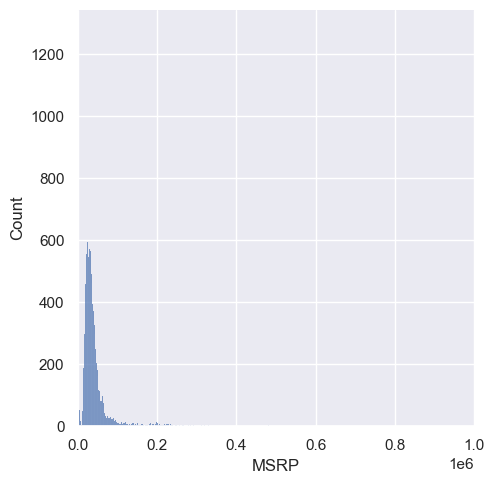

In [79]:
######################################
# Plotting a histogram of our target variable MSRP
######################################

sns.displot(df['MSRP']).set(xlim=(0,1000000))

plt.show()

> **Observation:**<br>
> For our objective variable, we can see a long tail in the plot above; as a result, we must take action to eliminate outliers.


### 3.3.1 Dealing with Outliers <a class="car" id="outlier-detection"></a>
* [Go to Data Prep](#data-prep)

> **Action Items**<br>
> * Reduce the MSRP range to exclude luxury vehicles costing more than \\$150,000 because there is little demand for these vehicles and those consumers who can afford them typically favor brand-new vehicles from dealerships over pre-owned vehicles. Additionally, I will remove any vehicles with a scrap value under \\$10,000. I make sure that our model will be trained on more realistic data by doing this.<br><br>
> * Ideally, a car's mileage should not exceed 40, thus we can delete any records with a car mileage of 40 or more.

Dataset after removing outliers: 9211


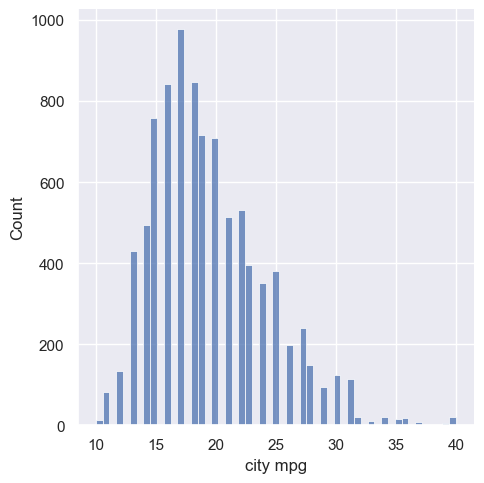

In [80]:
######################################
# Removing Outliers
######################################
df = df[ (df['MSRP']>=10000) & (df['MSRP']<=150000)]

df = df[df['city mpg']<=40]

print("Dataset after removing outliers: "+ str(df.shape[0]))

sns.displot(df['city mpg'])
plt.show()

> Above plot represents the distribution city MPG after removing outliers.

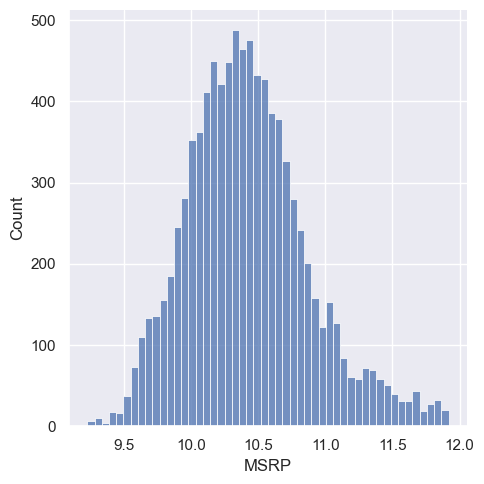

In [81]:
######################################
# Histogram of a normalized MSRP
######################################
sns.displot(np.log1p(df.MSRP))
plt.show()

> **Transformation:**<br>
> * Taking Log transformation gives a normalised form of our target which will be better for our model.

### 3.3.2 Data Correlations <a class="car" id="correlations"></a>
* [Go to Data Prep](#data-prep)

> **Plotting a heatmap**<br>
>  It is a color encoded matrix of [n X n] matrix where n is the number of features. For Example correlation of Engine HP and Engine cylinders is element in 4th row and 3rd column and is coming out to be 0.78. The advantage of using a heatmap is that it gives better representation of features and its properties.

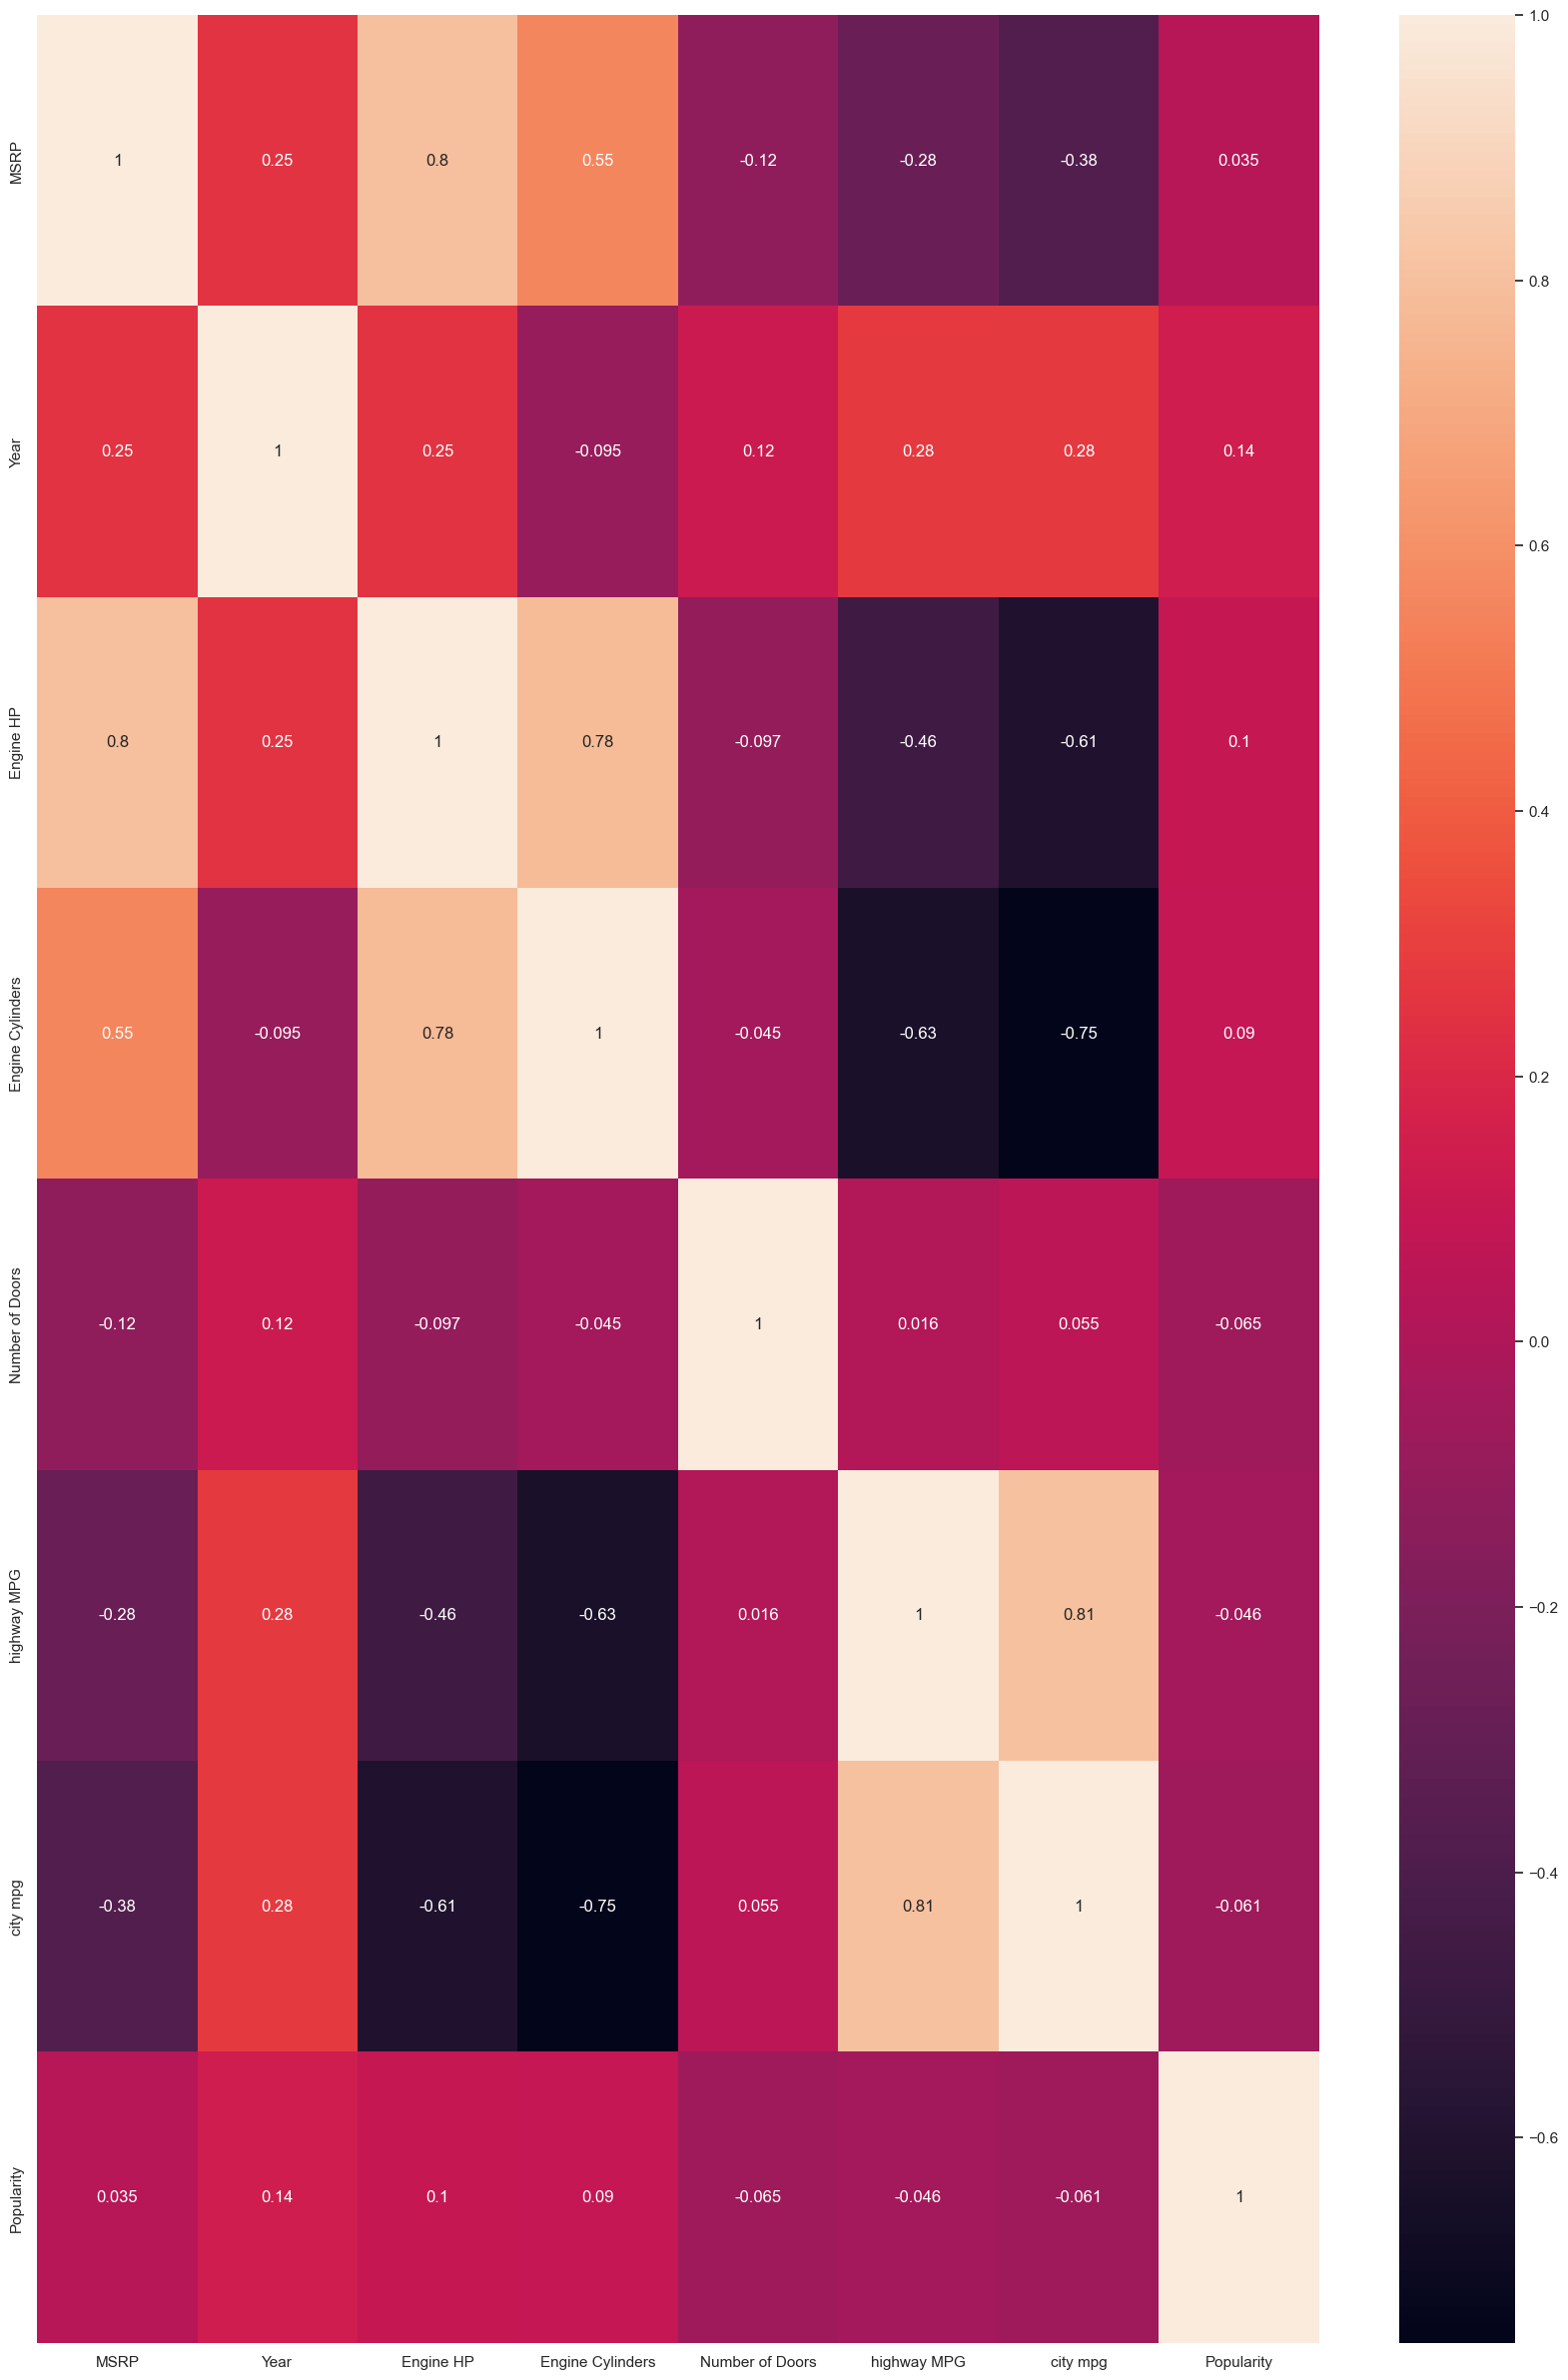

In [82]:
######################################
# Checking correlation values using heatmap function of seaborn
######################################
ax = sns.heatmap(df[numerical_features].corr(), annot=True)
plt.show()

> **Observations**<br>
> 
| **Feature**      | **Impact**             |   |   |   |   |
|------------------|------------------------|---|---|---|---|
| Year             | Slightly Positive      |   |   |   |   |
| Engine HP        | Strongly Positive      |   |   |   |   |
| Engine Cylinders | Strongly Positive      |   |   |   |   |
| Number of Doors  | Slightly negative      |   |   |   |   |
| highway MPG      | Negative               |   |   |   |   |
| city mpg         | Negative               |   |   |   |   |
| Popularity       | Very Slightly Positive |   |   |   |   |

> * Engine HP and Engine Cylinders are highly correlational therefore we can use one of the two features for our prediction model
> * Highway MPG and City MPG are also very correlational, therefore using one of those.
> * Popularity has almost no impact on MSRP so we can drop it.

## 3.4 Dealing with Categorical data <a class="car" id="categorical-data"></a>
* [Go to Data Prep](#data-prep)

In [83]:
######################################
# dealing with categorical variables
######################################

cat_df = df.select_dtypes(include = ['object','category'])
target_by_cats(pd.merge(df.MSRP,cat_df,left_index=True,right_index=True))

,mean,count,diff
Make,,,
Chevrolet,"32,442.60",945,"-5,193.84"
Ford,"33,625.58",665,"-4,010.86"
Toyota,"32,227.43",594,"-5,409.01"
Volkswagen,"29,900.28",535,"-7,736.16"
Nissan,"32,445.64",476,"-5,190.80"
GMC,"36,271.42",427,"-1,365.02"
Dodge,"31,182.34",414,"-6,454.10"
Honda,"28,071.34",382,"-9,565.10"
Cadillac,"58,500.03",381,"20,863.59"


,mean,count,diff
Model,,,
Silverado 1500,"38,876.22",156,"1,239.78"
Tundra,"36,985.12",129,-651.32
F-150,"40,747.05",126,"3,110.61"
Sierra 1500,"40,312.11",90,"2,675.67"
Frontier,"27,461.71",76,"-10,174.73"
...,...,...,...
RS 6,"82,700.00",1,"45,063.56"
Focus RS,"36,120.00",1,"-1,516.44"
DB7,"141,800.00",1,"104,163.56"


,mean,count,diff
Engine Fuel Type,,,
regular unleaded,"29,190.52",5215,"-8,445.92"
premium unleaded (required),"61,089.00",1548,"23,452.56"
premium unleaded (recommended),"41,648.06",1387,"4,011.62"
flex-fuel (unleaded/E85),"37,093.04",866,-543.40
diesel,"42,840.32",140,"5,203.88"
flex-fuel (premium unleaded required/E85),"98,814.44",27,"61,178.00"
flex-fuel (premium unleaded recommended/E85),"48,641.92",26,"11,005.48"
natural gas,"28,065.00",2,"-9,571.44"


,mean,count,diff
Transmission Type,,,
AUTOMATIC,"38,178.43",7047,541.99
MANUAL,"32,735.31",1756,"-4,901.13"
AUTOMATED_MANUAL,"49,369.20",408,"11,732.76"


,mean,count,diff
Driven_Wheels,,,
front wheel drive,"26,480.24",3592,"-11,156.20"
rear wheel drive,"45,240.73",2412,"7,604.29"
all wheel drive,"45,651.27",2089,"8,014.83"
four wheel drive,"42,098.45",1118,"4,462.01"


,mean,count,diff
Vehicle Size,,,
Midsize,"37,583.96",3564,-52.48
Compact,"31,073.45",3429,"-6,562.99"
Large,"47,867.07",2218,"10,230.63"


,mean,count,diff
Vehicle Style,,,
4dr SUV,"41,216.13",2363,"3,579.69"
Sedan,"37,664.74",2341,28.30
Coupe,"49,068.76",779,"11,432.32"
Crew Cab Pickup,"37,183.11",655,-453.33
Convertible,"53,204.09",548,"15,567.65"
4dr Hatchback,"23,228.17",532,"-14,408.27"
Wagon,"30,212.22",459,"-7,424.22"
Extended Cab Pickup,"29,439.62",453,"-8,196.82"
Passenger Minivan,"30,696.41",323,"-6,940.03"


> **categorical variables in use:**<br>
Engine fuel type--> can be reduced to less values<br>
Transmission type--> 3 values<br>
driven wheels --> 4 values<br>
Vehicle style--> this feature needs to be changed so that we can reduce the number of values.<br><br>
I am generalising the vehicle style to fixed set of values<br>
Vehicle size--> only 3 values<br><br>


Dropping car model cause this will have so many values

### 3.4.1 Reducing categorical data <a class="car" id="red-categorical-data"></a>
* [Go to Data Prep](#data-prep)

In [84]:
######################################
# Transforming categorical data
###################################### 
def vehicle_style(value):
    vehicle_set = set(['SUV','Sedan','Coupe','Hatchback','Convertible','Van','Minivan'])
    input_set = set(value.strip().split(' '))
    
    if (vehicle_set & input_set):
        return list(vehicle_set & input_set)[0]
    else:
        return 'others'

        
        
print("Vehicle style unique values before reduction :" +str(df['Vehicle Style'].nunique()))

df['Vehicle_Style'] = df['Vehicle Style'].apply(vehicle_style)
print("Vehicle Style unique values After reduction :" +str(df['Vehicle_Style'].nunique()))    

# df.drop(columns = ['Model'], inplace  = True)

#taking the top 4 values of make and renaming remaining values to 'Others'

print("Make unique values before reduction :" +str(df['Make'].nunique()))

df['Make'] = df['Make'].astype('category')

others = df['Make'].value_counts().index[4:]
label = 'Other'

df['Make'] = df['Make'].cat.add_categories([label])
df['Make'] = df['Make'].replace(others, label)

print("Make unique values after reduction :" +str(df['Make'].nunique()))

#Modifying Engine_fuel_type
print("Engine Fuel type unique values before reduction :" +str(df['Engine Fuel Type'].nunique()))

df ['Engine Fuel Type'] =df['Engine Fuel Type'].str.split('(').str[0]

print("Engine Fuel type unique values after reduction :" +str(df['Engine Fuel Type'].nunique()))


    
# df['market_cat_new'] = df['Market Category'].str.split(',',n=-1).apply(lambda x: x[-1])









Vehicle style unique values before reduction :16
Vehicle Style unique values After reduction :8
Make unique values before reduction :40
Make unique values after reduction :5
Engine Fuel type unique values before reduction :8
Engine Fuel type unique values after reduction :5


## 3.5 Multivariate Analysis <a class="car" id="mul-analysis"></a>
* [Go to Data Prep](#data-prep)

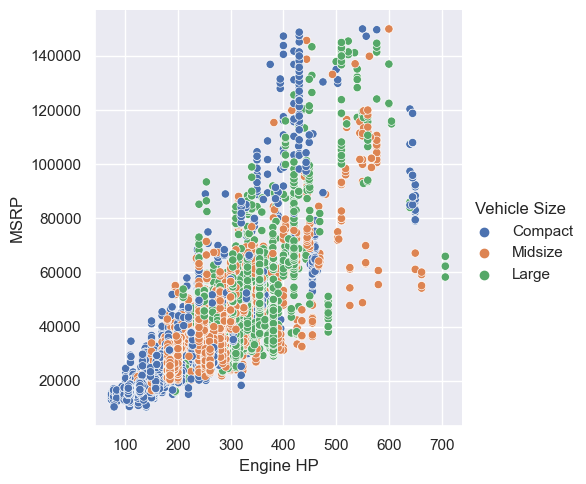

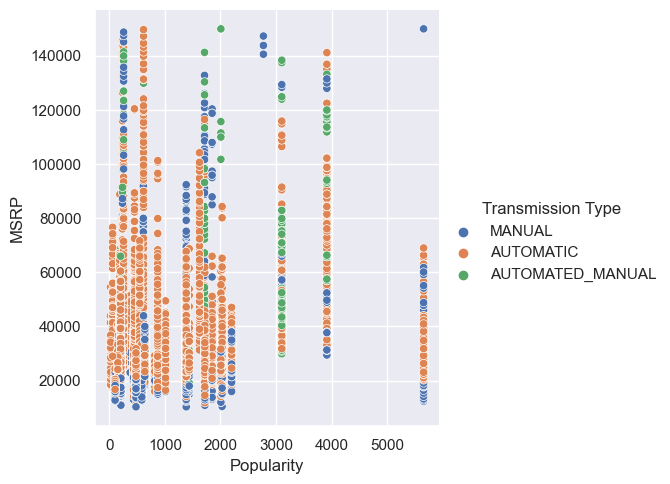

In [85]:
######################################
# dealing with categorical variables
######################################
#plotting multi variate plots
sns.set(rc={'figure.figsize':(20.7,30.27)})
sns.relplot(data=df, x="Engine HP", y="MSRP", hue = "Vehicle Size" )

sns.relplot(data=df, x="Popularity", y="MSRP", hue = "Transmission Type" )


# sns.relplot(data=df, x="Engine HP", y="Engine Cylinders")

plt.show()

### Multivariate Analysis outcome:<br><Br>

> **First Plot**<br>
> In the first plot we can see the scattered values of Engine horsepower vs MSRP. Here are some of my observations:
> * As Horse Power increases, Price of the vehicle also increases
> * We also have an additional dimension for vehicle size. From the data compact vehicles with more HP gets a better price.<br><br><br>
    
> **Second Plot** <br> 
> This Plot has Popularity vs MSRP. I want to check if popularity has any relation with our target. From the heatmap, there is no such evidence. <br>
> * As expected popularity has least correlation with the Price. It is confirmed that there is no linearity between popularity and Price.<br>
> * There is a huge chunk of data which has low popularity and low MSRP.





## 3.5 Feature Transformation <a class="car" id="feature-transform"></a><br>

> **Objective:** <br>
> * 1. Apply log-transform to MSRP<br>
> * 2. Encode categorical variables<br><br>


* [Go to Data Prep](#data-prep)

In [86]:
######################################
# Transforming features for our model
######################################
# Create a new version of 'MSRP' - a log tranformation
df['ln_msrp'] = np.log1p(df['MSRP'])

# categorical variables
cat_vars = ['Make','Engine Fuel Type','Transmission Type','Driven_Wheels','Vehicle Size','Vehicle_Style']
# Loop over categorical vars and encode each one
for var in cat_vars:
    df[var] = df[var].astype("category")

df = pd.get_dummies(df,columns=cat_vars, prefix_sep='_', drop_first=True)

In [87]:
#list(df.columns)

> **Creating a test/train split**

In [88]:
predictors =['Year','Engine HP','Number of Doors','city mpg',
             'Make_Ford', 'Make_Ford', 'Make_Toyota', 'Make_Volkswagen', 'Make_Other',
            'Engine Fuel Type_flex-fuel ','Engine Fuel Type_natural gas','Engine Fuel Type_premium unleaded ',
            'Engine Fuel Type_regular unleaded', 'Transmission Type_AUTOMATIC', 'Transmission Type_MANUAL',
             'Driven_Wheels_four wheel drive', 'Driven_Wheels_front wheel drive', 'Driven_Wheels_rear wheel drive',
             'Vehicle Size_Large', 'Vehicle Size_Midsize', 'Vehicle_Style_Coupe', 'Vehicle_Style_Hatchback',
             'Vehicle_Style_Minivan', 'Vehicle_Style_SUV', 'Vehicle_Style_Sedan', 'Vehicle_Style_Van',
             'Vehicle_Style_others']

target = ['ln_msrp']

X = df[predictors]
y = df[target]

# Split data
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state=2)

# 4. Machine Learning Model Implementation<a class="car" id="ml-model"></a>
> * [Model1](#first-model)
> * [Model2](#second-model)
> * [Model3](#third-model)

-


<br><br>
* [Go to Top](#table-of-content)

> **Model 1** <a class="car" id="first-model"></a>
<br>
> Objectives:<br>
> * I am choosing Engine HP as my dependent variable for this model. This is the most obvious choice since it has strongest correlation with our target. Also HorsePower can be related to more power and more power means more money in car world.

In [89]:
predictor1 = ['Engine HP']

model = LinearRegression()
model.fit(X_train[predictor1],y_train)

# Display Output
train_test_metrics(X_train[predictor1],X_test[predictor1],y_train,y_test,model)



        Train  Test
R2       0.70  0.71
Adj-R2   0.70  0.71
MAE      0.19  0.19
MAPE     1.80  1.80


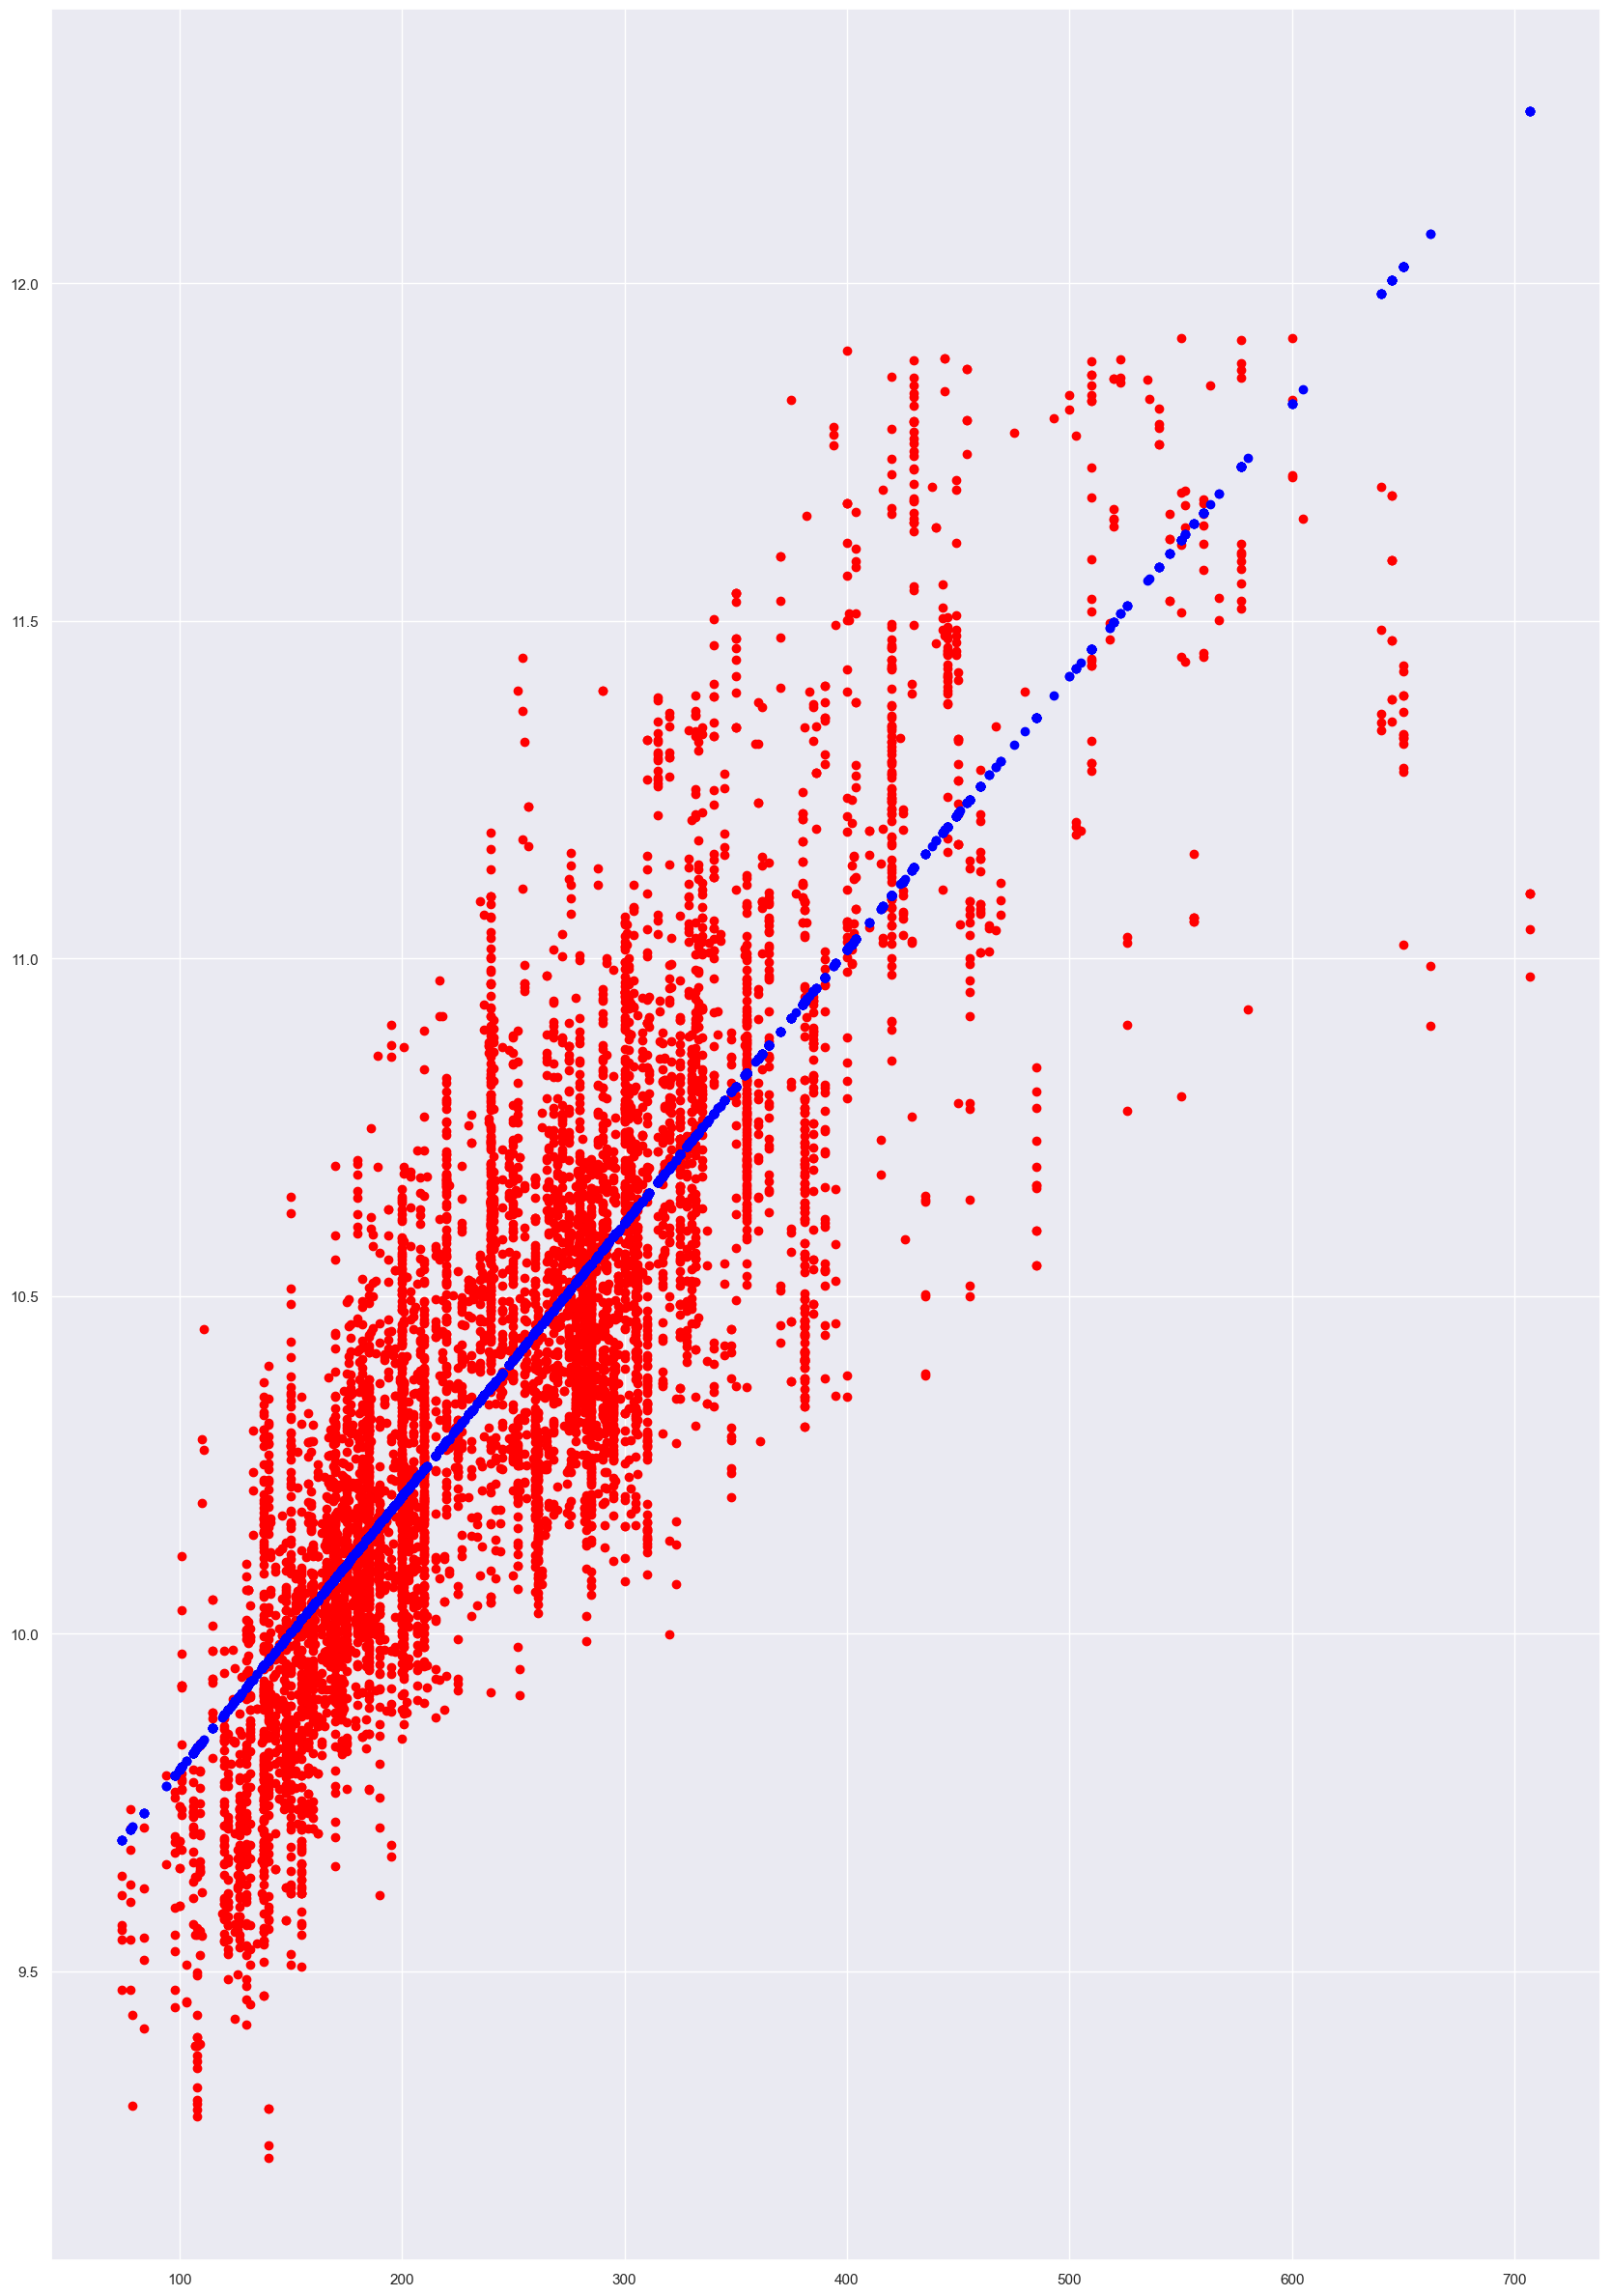

In [90]:
######################################
#plotting prediction vs actual values scatter plot to check for overfitting
######################################

y_pre_train = model.predict(X_train[predictor1])
y_pre_test = model.predict(X_test[predictor1])

df_model1 = pd.merge(X_train[predictor1].reset_index(),y_train.reset_index(),left_index=True,right_index=True).reset_index()

df_model_1 = pd.merge(df_model1,pd.DataFrame(y_pre_train,columns = ['lnmsrp_pred']),left_index=True,right_index=True)

plt.scatter(df_model_1['Engine HP'], df_model_1['ln_msrp'], color='red')
plt.scatter(df_model_1['Engine HP'], df_model_1['lnmsrp_pred'], color='blue')

plt.show()

> **Observations**<br>
> * This plot is (predicted and actual MSRP) vs HP.
> * There is no sign of overfitting on our test data and we can see a straight linear relationship.

In [91]:
#CAlculate parameter estimates or coefficient of our model
# since we took log transformation of the target variable therefore we are using the below function to calculate coeff of our linear model
print("Effect Of HP on MSRP: " + str(round((math.exp(model.coef_[0])-1)*100,2)))

Effect Of HP on MSRP: 0.41


> **Model 1 Summary**<br><br>
> MAPE?
> * MAPE of our test and training data is coming out to be less than 2 percent since we took a log transformation of our target variable.<br>
.
> * Our data fits perfectly and we can see a linear relationship for our predicted values. Accuracy is coming out to be 70% and 71% for our test and train data respectively.<br>

> Model Parameter<br>
This gives the percent increase (or decrease) in the response for every one-unit increase in the independent variable so going by this definition a one unit increase in our predictor variable i.e Engine HP, we expect our MSRP to increase by 41%.<br>

> Overfitting?<br>
> There is clearly no overfitting in the model 1. Simply by looking at the error metrics for our test and train data which are quite similar. Mean Absolute error is also very low therefore no sign of overfitting which was expected since we are using a single feature Same can be confirmed from the plot above.

> **Model 2** <a class="car" id="second-model"></a>
<br>
> Objectives:<br>
> * Choosing a numerical and a categorical variable together. <br>
> I am going with horse power and vehicle size as we saw a relation between HP and vehicle size in one of the plots above. I want to check how it will affect the pricing and accuracy of our model.<br>
> * Also I want to check what will happen if i use the indicator variables as both slope shifters and indicator shifters.

In [92]:

######################################
# creating slope shifters
######################################
X_train = X_train.assign(HP_Vehicle_Size_large = X_train['Engine HP'] * X_train['Vehicle Size_Large'])
X_test = X_test.assign(HP_Vehicle_Size_large = X_test['Engine HP'] * X_test['Vehicle Size_Large'])

X_train = X_train.assign(HP_Vehicle_Size_mid = X_train['Engine HP'] * X_train['Vehicle Size_Midsize'])
X_test = X_test.assign(HP_Vehicle_Size_mid = X_test['Engine HP'] * X_test['Vehicle Size_Midsize'])

predictor2 = ['Engine HP','Vehicle Size_Large', 'Vehicle Size_Midsize','HP_Vehicle_Size_large','HP_Vehicle_Size_mid']
model2 = LinearRegression()
model2.fit(X_train[predictor2],y_train)

# Display Output
train_test_metrics(X_train[predictor2],X_test[predictor2],y_train,y_test,model2)

        Train  Test
R2       0.71  0.72
Adj-R2   0.71  0.72
MAE      0.19  0.18
MAPE     1.80  1.80


In [93]:
#print(model2.coef_)
print('HP impact on MSRP when vehicle size is small:', str(round((math.exp(model2.coef_[0][0])-1)*100,2)))
print('Large Vehicle size effect on MSRP', str(round((math.exp(model2.coef_[0][1])-1)*100,2)))
print('Medium Vehicle size effect on MSRP', str(round((math.exp(model2.coef_[0][2])-1)*100,2)))
print('HP effect when vehicle size is Large:', str(round((math.exp(model2.coef_[0][0])-1)*100,2)+
                                           round((math.exp(model2.coef_[0][3])-1)*100,2)))
     
print('HP effect when vehicle size is Medium:',str(round((math.exp(model2.coef_[0][0])-1)*100,2)+
                                           round((math.exp(model2.coef_[0][4])-1)*100,2)))

HP impact on MSRP when vehicle size is small: 0.45
Large Vehicle size effect on MSRP 18.4
Medium Vehicle size effect on MSRP 29.88
HP effect when vehicle size is Large: 0.38
HP effect when vehicle size is Medium: 0.36


> **Model 2 Summary**<br><br>
> MAPE of our test and train data is coming out to be 1.8%. again we are taking log transformation of our MSRP. Note this value is same when we were using just HP for our predictions.<br>

> Model Parameter( *I still have some doubts in this but here is my understanding*)<br>
> The last two features are slope shifters and it gives the percentage change in MSRP from unit change in horse power given that vehicle size is fixed. For Example if vehicle size is large, the percentage value is coming out to be 38%.<br>
> We have intercept shipters such as Large vehicle size and medium vehicle size coefficients which determine the percentage in MSRP if these values are true.

<br>

> Overfitting?<br>
> Our train and test data provides similar values for mean absolute error therefore there is no sign of overfitting or under fitting. In other words the data fits our model perfectly.

> **Model 3** <a class="car" id="third-model"></a>
<br>
> Objectives:<br>
> * Choosing all relevant categorical and numerical variables. <br>
> * We have transformed 3 categorical variables i.e Engine Fuel Type, Vehicle Sedan and Make

In [94]:
predictor3 =['Year','Engine HP','Number of Doors','city mpg',
             'Make_Ford', 'Make_Ford', 'Make_Toyota', 'Make_Volkswagen', 'Make_Other',
            'Engine Fuel Type_flex-fuel ','Engine Fuel Type_natural gas','Engine Fuel Type_premium unleaded ',
            'Engine Fuel Type_regular unleaded', 'Transmission Type_AUTOMATIC', 'Transmission Type_MANUAL',
             'Driven_Wheels_four wheel drive', 'Driven_Wheels_front wheel drive', 'Driven_Wheels_rear wheel drive',
             'Vehicle Size_Large', 'Vehicle Size_Midsize', 'Vehicle_Style_Coupe', 'Vehicle_Style_Hatchback',
             'Vehicle_Style_Minivan', 'Vehicle_Style_SUV', 'Vehicle_Style_Sedan', 'Vehicle_Style_Van',
             'Vehicle_Style_others']

model3 = LinearRegression()
model3.fit(X_train[predictor3],y_train)

# Display Outputb
train_test_metrics(X_train[predictor3],X_test[predictor3],y_train,y_test,model3)

        Train  Test
R2       0.82  0.82
Adj-R2   0.82  0.82
MAE      0.15  0.14
MAPE     1.40  1.40


In [95]:
#print(model3.coef_)

for i in range(len(predictor3)):
    print("% Impact of {} on target: ".format(predictor3[i])+str(round((math.exp(model3.coef_[0][i])-1)*100,2)))
    

% Impact of Year on target: 0.65
% Impact of Engine HP on target: 0.33
% Impact of Number of Doors on target: 1.77
% Impact of city mpg on target: 0.41
% Impact of Make_Ford on target: 0.62
% Impact of Make_Ford on target: 0.62
% Impact of Make_Toyota on target: 0.62
% Impact of Make_Volkswagen on target: 0.62
% Impact of Make_Other on target: 2.17
% Impact of Engine Fuel Type_flex-fuel  on target: 6.69
% Impact of Engine Fuel Type_natural gas on target: 8.85
% Impact of Engine Fuel Type_premium unleaded  on target: -32.07
% Impact of Engine Fuel Type_regular unleaded on target: -3.77
% Impact of Transmission Type_AUTOMATIC on target: -19.81
% Impact of Transmission Type_MANUAL on target: -32.81
% Impact of Driven_Wheels_four wheel drive on target: -3.74
% Impact of Driven_Wheels_front wheel drive on target: -14.71
% Impact of Driven_Wheels_rear wheel drive on target: 0.18
% Impact of Vehicle Size_Large on target: -11.33
% Impact of Vehicle Size_Midsize on target: -7.88
% Impact of Veh

> **Model 3 Summary**<br><br>
> Mape of test and train are coming exactly same. It seems somewhat surprising to me too. I have looked at all possible options could not come up with an explanation why all metrics are same for test and train data. MAPE is lowest for this model and is coming out to be 1.4 <br>

> Model Parameter<br>
This gives the percent increase (or decrease) in the response for every one-unit increase in the independent variable. All variables have a variable impact on our data. I have listed out the percentage changes for each parameter.<br>

> Overfitting?<br>
> Our data fits perfectly since the mean absolute error is very low i.e around .14 for both our test and train data.

# 5. Deployment of Model <a class="car" id="model-deployment"></a>

* [Go to Top](#table-of-content)

# Conclusion <a class="car" id="Conclusion"></a>

> **How did our model performed?**<br>
> Since all of our metrics were nearly identical for both our test and train data, our model performed remarkably well. Our most recent model has an accuracy of 82%, which is, in my opinion, quite excellent. This might be the case because we eliminated every skewness and outlier from our data. Because of this, all of our dependent and independent variables had normal distributions, which is advantageous for our models.

> **What could be proposed from our model outcome?**<br>
> It is evident from the model specifications that there is a higher demand for coupes and hatchbacks than for SUVs or sedans. The cost of the autos as a whole is increased by these car designs. The high maintenance and insurance costs of large used vehicles may be the reason for this market's inclination toward other niches. Additionally, consumers are becoming more informed and environmentally conscious, which raises the cost of vehicles using flex fuel or natural gas.

> **Anything different could be done.....**<br>
> Before purchasing a used car, a buyer considers additional factors such the car's interior, the engine's condition, and the odometer reading. As a result, adding such elements to our model can help us anticipate our target variable accurately and add realism to the model.

> **I would like to communicate to the leadership that......**<br>
> Because there is such a high demand for tiny automobiles, such as coupes and hatchbacks, I will push automakers to expand this market.
Because automobile owners are increasingly environmentally conscious and have switched to cleaner methods of operation and better fuel, car owners should should be encouraged to go green. 


* [Go to Top](#table-of-content)